In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

What transformations might be useful when working with images?
Resizing, normalizing, padding, cropping, rotation, flipping...

In [3]:
# Preprocessing
transform = transforms.Compose([
   transforms.Pad(2),  # Pad 28x28 images to 32x32
   transforms.ToTensor(),    #Convert images to tensors
])
batch_size = 64


In [4]:
train_dataset = datasets.FashionMNIST(root="./data", train= True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.97MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}
def plot_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()

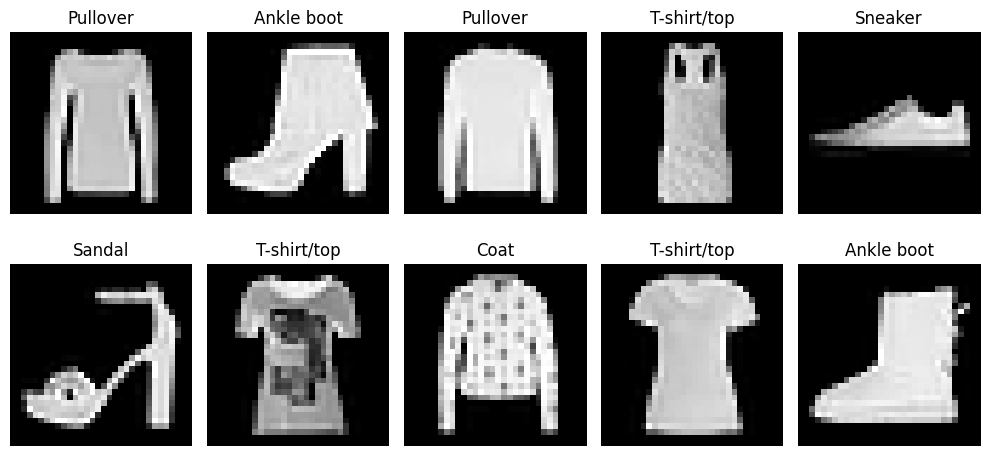

In [6]:
plt.show()
plot_sample_images(train_loader)

How does reducing the dimensionality help the model? Reducing the dimensionality forces the model to learn the most essential features, improving generalization and noise reduction.

What happens if the latent space is too small or too large? If the latent space is too small, the model may lose important details, resulting in blurry or incomplete reconstructions. If the latent space is too large, the model may memorize the data instead of learning meaningful features, reducing its ability to generalize.


In [7]:
# Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Initialize the Autoencoder model.
        - input_shape: The shape of the input images (1, 32, 32) for grayscale images.
        - latent_dim: The number of neurons in the latent space.
        """
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional layer: Convert 1-channel input into 32 feature maps.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # acivation function

            # Second convolutional layer: Reduce spatial dimensions further.
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), #acivation function

            # Third convolutional layer: Extract higher-level features.
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Add another Conv2D layer with 128 filters, kernel size 3, stride 2, padding 1
            nn.ReLU()  #acivation function
            )

        # Dynamically calculate the flattened size after encoding
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # Latent space (fully connected layer)
        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),  # Flatten the encoded features
            nn.Linear(flattened_size, latent_dim)  # Replace xxx with the latent dimension
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),  # Map latent space back to the feature map
            nn.Unflatten(decode_shape[0],decode_shape[1:]),  # Reshape to match the encoded feature map

            # Transposed Convolution layers (Decoder)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Add a conv transpose 2d
            nn.ReLU(), # acivation function


            # Next deconvolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Add a ConvTranspose2d layer reducing from 64 channels to 32 channels and  kernel_size=3, stride=2, padding=1, output_padding=1
            nn.ReLU(), # acivation function

            # Final deconvolution layer: Convert back to single-channel grayscale image
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # acivation function
            #Output values should be between 0 and 1
        )

    def calculate_flattened_size(self, model, input_shape):
        """
        Helper function to determine the flattened size after the encoder.
        - model: The encoder model.
        - input_shape: The shape of the input tensor.
        Returns:
        - The flattened size (number of features) and output shape.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Create a batch of one image
            output = model(dummy_input)
            return output.numel(), output.shape  # Return total number of elements and shape

    def forward(self, x):
        """
        Forward pass through the Autoencoder.
        - x: Input image tensor.
        Returns:
        - Reconstructed image
        - Latent space representation
        """
        x = self.encoder(x)  # Pass through the encoder
        latent = self.fc(x)  # Project into latent space
        x = self.decoder(latent)  # Decode the latent representation
        return x, latent



In [8]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = Autoencoder()
image_test,latent_space = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs):
    """
    Train the Autoencoder model.

    - model: The Autoencoder instance.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - epochs: Number of training iterations.
    """
    model.to(device)# Move model to device
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # Choose a suitable learning rate
    loss_fn = nn.MSELoss() # Define the loss function
    print("Start Training...")
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_loss = 0
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, _ in tqdm_loader:
            x = x.to(device) # Move batch to device
             # Forward pass: get reconstructed output
            recon_x, _ = model(x)
            # Compute reconstruction loss loss = xxx  # Compute MSE loss between `recon_x` and `x`

            loss = loss_fn(recon_x, x)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

            total_loss += loss.item() # Accumulate batch loss
	    # Update tqdm progress bar with loss
            tqdm_loader.set_postfix(loss=loss.item())

        # Calculate average loss over the epoch
        avg_train_loss = total_loss / len(train_loader.dataset)
	    # for val get Mean Squared Error and cross_entropy
        avg_val_loss,ce_losss = evaluate_model(model, val_loader)
        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)


        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {100*avg_train_loss:.6f} %, Val Loss: {100*avg_val_loss:.6f} %,  Val Loss cross_entropy: {100*ce_losss:.6f} %")
    # Plot training and validation loss
    plot_training_loss(train_losses, val_losses)

# Evaluation function
def evaluate_model(model, loader):
    """
    Evaluate the model on validation data.

    - model: Trained Autoencoder model.
    - loader: DataLoader for validation data.

    Returns:
    - avg_loss: The average loss across all validation samples.
    """


    model.eval() # Set model to evaluation mode
    total_loss = 0
    loss_fn = nn.MSELoss() # Use the same loss function as training
    ce_losss=0
    with torch.no_grad():  # No need to compute gradients
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)
            recon_x,_ = model(x) # Get reconstruction
            loss = loss_fn(recon_x, x) # Compute loss between recon_x and x
            ce_loss= F.binary_cross_entropy(recon_x, x )
            total_loss += loss.item()
            ce_losss+=ce_loss

    avg_loss = total_loss / len(loader.dataset)
    ce_losss/=len(loader.dataset)
    return avg_loss,ce_losss

def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()



Start Training...


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 104.62it/s]


Epoch [1/10], Train Loss: 0.085216 %, Val Loss: 0.055091 %,  Val Loss cross_entropy: 0.466881 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 94.88it/s]


Epoch [2/10], Train Loss: 0.051010 %, Val Loss: 0.049184 %,  Val Loss cross_entropy: 0.455397 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 111.03it/s]


Epoch [3/10], Train Loss: 0.047538 %, Val Loss: 0.046589 %,  Val Loss cross_entropy: 0.446745 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 93.65it/s]


Epoch [4/10], Train Loss: 0.045784 %, Val Loss: 0.045084 %,  Val Loss cross_entropy: 0.439464 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 110.17it/s]


Epoch [5/10], Train Loss: 0.044462 %, Val Loss: 0.043887 %,  Val Loss cross_entropy: 0.433618 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 110.80it/s]


Epoch [6/10], Train Loss: 0.043457 %, Val Loss: 0.043295 %,  Val Loss cross_entropy: 0.430140 %


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.31it/s] 


Epoch [7/10], Train Loss: 0.042627 %, Val Loss: 0.042616 %,  Val Loss cross_entropy: 0.427203 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 98.11it/s] 


Epoch [8/10], Train Loss: 0.042001 %, Val Loss: 0.041871 %,  Val Loss cross_entropy: 0.424399 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 111.18it/s]


Epoch [9/10], Train Loss: 0.041403 %, Val Loss: 0.041204 %,  Val Loss cross_entropy: 0.422137 %


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 110.71it/s]


Epoch [10/10], Train Loss: 0.040933 %, Val Loss: 0.041089 %,  Val Loss cross_entropy: 0.421038 %


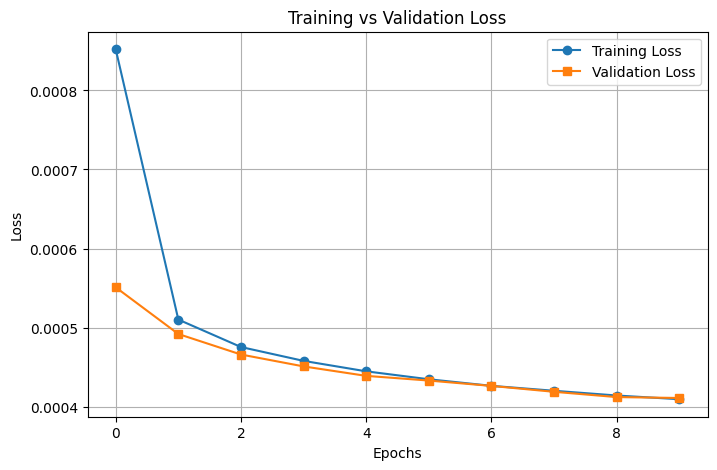

In [10]:
# Instantiate and train the model
autoencoder = Autoencoder()
train_model(autoencoder, train_loader, val_loader, epochs=10)

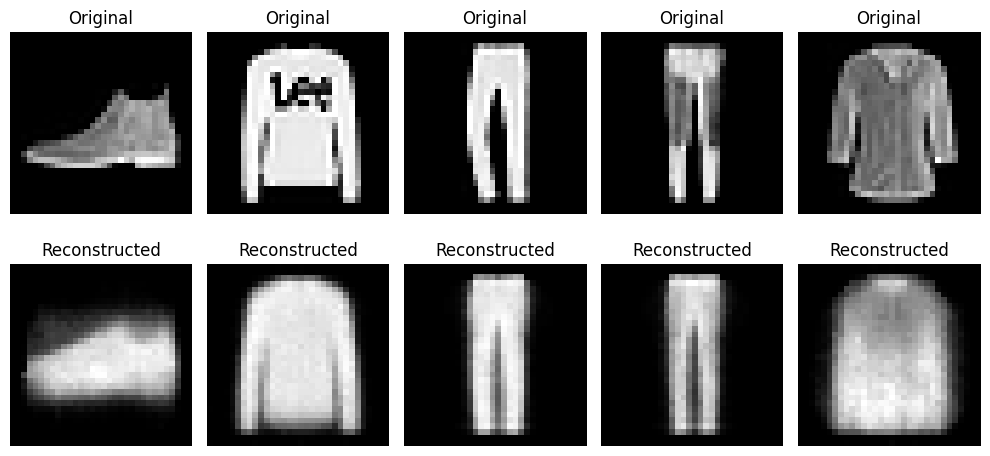

In [11]:
# Function to plot reconstructions
def plot_reconstructions(model, loader, ex=True):
    model.eval()  # Set the model to evaluation mode
    model = model.to("cpu")  # Move model to CPU for visualization

    with torch.no_grad():
        if ex:
            for x, _ in loader:  # Extract a batch from DataLoader
                recon_x, _ = model(x)
                break
        else:
            x = loader  # Directly use provided latent vectors
            recon_x = model.decoder(x)  # Decode latent space samples

    # Convert tensors to NumPy for plotting
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Plot Original images (only if batch came from real data)
        if ex:
            plt.subplot(2, 5, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, 5, i + 6)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


plot_reconstructions(autoencoder, val_loader)

How could you improve the model to get sharper images?
Add extra layers with small kernel size, improve loss function, data augmentation...

In [14]:

# Initialize lists to store embeddings and corresponding labels
embeddings = []
labels = []

# Move the Autoencoder to the appropriate device
autoencoder = autoencoder.to(device)
# Disable gradient computation for efficiency
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches
        x = x.to(device)  # Move batch to device
        # Pass the images through the encoder to get latent space representations
        _, latent = autoencoder(x)  # Replace xxx to correctly call the Autoencoder and extract embeddings
        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

# Combine embeddings and labels into single arrays
embeddings = np.concatenate(embeddings, axis=0)  # Use NumPy to concatenate the embeddings along axis 0
labels = np.concatenate(labels, axis=0)  # Similarly, concatenate the labels

# Identify unique class labels
unique_labels = np.unique(labels)
autoencoder=autoencoder.to("cpu")


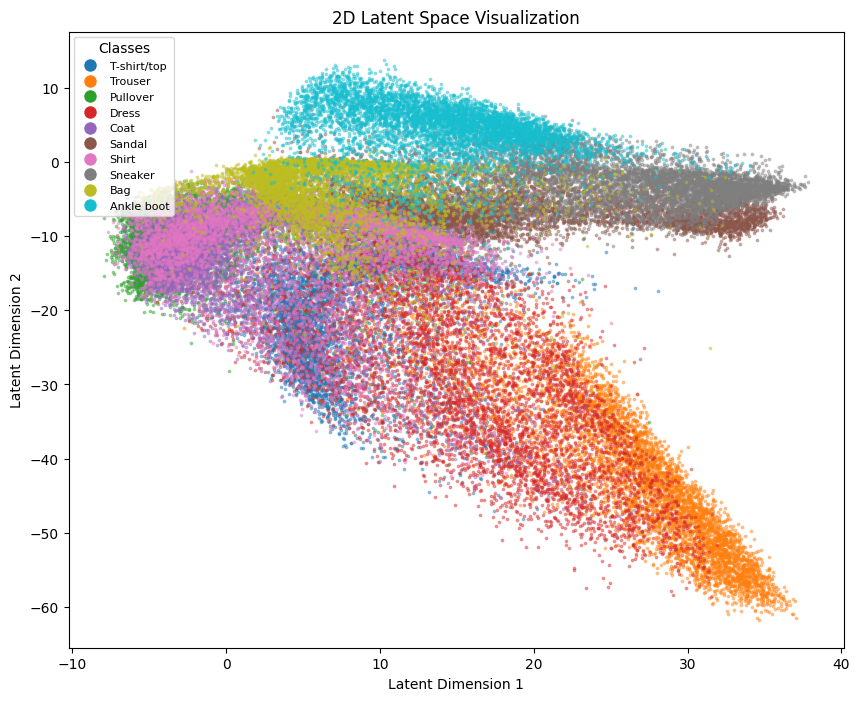

In [15]:
# Plot the 2D embeddings

# Generate more distinguishable colors for each class using a categorical colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()


Would images of similar clothing types cluster together and are they well represented ?
Yes , and yes ther are well represented

Generated Latent Samples:
 tensor([[ 26.5991,  -1.4688],
        [ 30.2847, -27.0861],
        [  5.4729,   2.9458],
        [  5.0551, -39.8824],
        [  6.7717, -29.0304]])


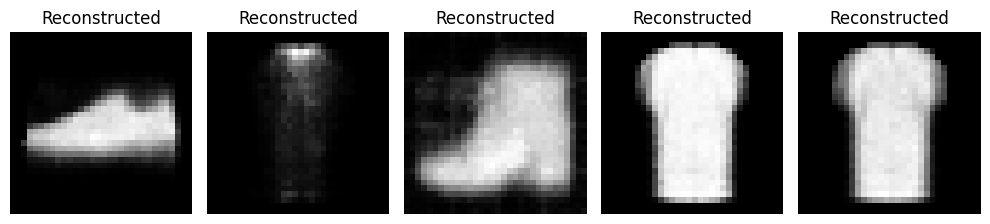

In [16]:
# Generate latent space samples for visualization
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = torch.tensor(np.random.uniform(mins, maxs, size=(5, 2)), dtype=torch.float32)

# Print the sampled latent vectors
print("Generated Latent Samples:\n", sample)

# Plot reconstructions from sampled latent space
plot_reconstructions(autoencoder, sample, ex=False)

Are there any objects not well reconstructed ?
Yes, Trousers

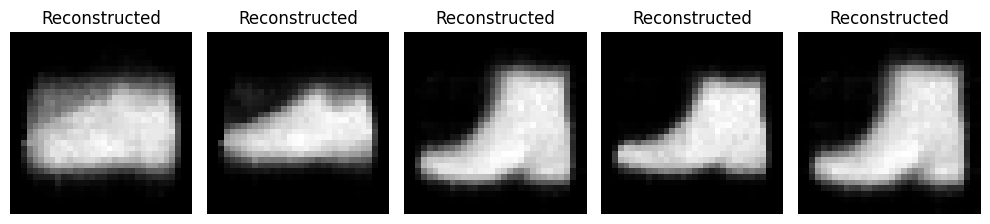

In [18]:
x_sample = torch.tensor([[12.,0],[20.,0],[12.,5],[20.,5],[10.,5]]) # Example input
plot_reconstructions(autoencoder, x_sample, ex=False)

Plot examples of Trouser ?

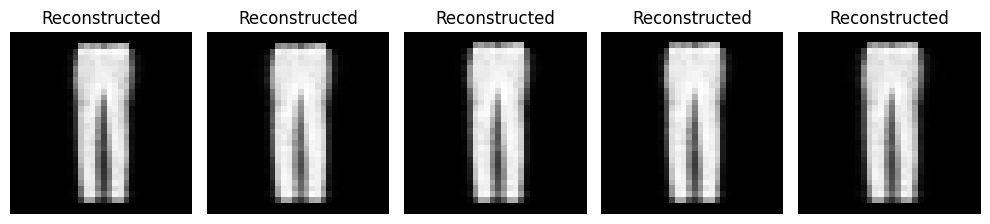

In [22]:
x_sample = torch.tensor([[34.,-55],[31.,-55],[34.,-59],[34.,-59],[30.,-50]]) # Example input
plot_reconstructions(autoencoder, x_sample, ex=False)

In [21]:
#save the model
torch.save(autoencoder.state_dict(), "VAmodel_state_dict.pth")